## Model Usage Demonstration (Top 3 Models)

This section demonstrates how the final top-3 trained models are used to predict the disposition of Kepler Objects of Interest (KOIs).

Key points:
- Uses the saved NASA standard scaler (no refitting)
- Uses the final retrained top-3 models
- Produces human-readable predictions and confidence scores
- Includes an ensemble (majority-vote) verdict

In [ ]:

# Import libraries and set paths
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

In [2]:
DATA_PATH = "../data/processed/feature_engineered_data.csv"
TOP3_PATH = Path("../models/top_3")

In [ ]:
# Load Final Models & Scaler
extra_trees = joblib.load(TOP3_PATH / "final_extra_trees.pkl")
random_forest = joblib.load(TOP3_PATH / "final_random_forest.pkl")
gradient_boosting = joblib.load(TOP3_PATH / "final_gradient_boosting.pkl")

scaler = joblib.load(TOP3_PATH / "nasa_standard_scaler.pkl")
metadata = joblib.load(TOP3_PATH / "final_model_metadata.pkl")

MODELS = {
    "Extra Trees": extra_trees,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting
}

LABEL_MAP = metadata["label_mapping"]
FEATURES = metadata["features_used"]

In [ ]:
# Load Data for Usage
df = pd.read_csv(DATA_PATH)

# Features and true labels (labels used only for comparison)
X_usage = df[FEATURES]
y_true = df["koi_disposition"].map(LABEL_MAP)

In [ ]:
# Apply NASA Standard Scaler
X_usage_scaled = scaler.transform(X_usage)

In [14]:
def predict_with_confidence(model, X):
    preds = model.predict(X)
    if hasattr(model, "predict_proba"):
        conf = model.predict_proba(X).max(axis=1)
    else:
        conf = np.ones(len(preds))
    return preds, conf

In [ ]:
# Run Predictions (Top 3 Models)
usage_results = pd.DataFrame()

for name, model in MODELS.items():
    preds, conf = predict_with_confidence(model, X_usage)
    usage_results[f"{name}_prediction"] = [LABEL_MAP[p] for p in preds]
    usage_results[f"{name}_confidence"] = conf

usage_results["True_Label"] = y_true
usage_results.head(10)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


,Extra Trees_prediction,Extra Trees_confidence,Random Forest_prediction,Random Forest_confidence,Gradient Boosting_prediction,Gradient Boosting_confidence,True_Label
0,CANDIDATE,1.0000,CANDIDATE,0.975,CANDIDATE,0.912047,CANDIDATE
1,CANDIDATE,1.0000,CANDIDATE,0.945,CANDIDATE,0.941218,CANDIDATE
2,CONFIRMED,1.0000,CONFIRMED,0.995,CONFIRMED,0.993877,CONFIRMED
3,CONFIRMED,1.0000,CONFIRMED,0.995,CONFIRMED,0.998050,CONFIRMED
4,CANDIDATE,1.0000,CANDIDATE,0.930,CANDIDATE,0.843760,CANDIDATE
5,CANDIDATE,1.0000,CANDIDATE,0.925,CANDIDATE,0.926203,CANDIDATE
6,CANDIDATE,1.0000,CANDIDATE,0.930,CANDIDATE,0.938560,CANDIDATE
7,CANDIDATE,1.0000,CANDIDATE,0.800,CANDIDATE,0.764497,CANDIDATE
8,CONFIRMED,0.9975,CONFIRMED,1.000,CONFIRMED,0.999595,CONFIRMED
9,CANDIDATE,1.0000,CANDIDATE,0.970,CANDIDATE,0.914331,CANDIDATE


In [19]:
def majority_vote(row):
    votes = [
        row["Extra Trees_prediction"],
        row["Random Forest_prediction"],
        row["Gradient Boosting_prediction"]
    ]
    return max(set(votes), key=votes.count)

usage_results["Ensemble_Verdict"] = usage_results.apply(majority_vote, axis=1)
usage_results.head(10)

,Extra Trees_prediction,Extra Trees_confidence,Random Forest_prediction,Random Forest_confidence,Gradient Boosting_prediction,Gradient Boosting_confidence,True_Label,Ensemble_Verdict
0,CANDIDATE,1.0000,CANDIDATE,0.975,CANDIDATE,0.912047,CANDIDATE,CANDIDATE
1,CANDIDATE,1.0000,CANDIDATE,0.945,CANDIDATE,0.941218,CANDIDATE,CANDIDATE
2,CONFIRMED,1.0000,CONFIRMED,0.995,CONFIRMED,0.993877,CONFIRMED,CONFIRMED
3,CONFIRMED,1.0000,CONFIRMED,0.995,CONFIRMED,0.998050,CONFIRMED,CONFIRMED
4,CANDIDATE,1.0000,CANDIDATE,0.930,CANDIDATE,0.843760,CANDIDATE,CANDIDATE
5,CANDIDATE,1.0000,CANDIDATE,0.925,CANDIDATE,0.926203,CANDIDATE,CANDIDATE
6,CANDIDATE,1.0000,CANDIDATE,0.930,CANDIDATE,0.938560,CANDIDATE,CANDIDATE
7,CANDIDATE,1.0000,CANDIDATE,0.800,CANDIDATE,0.764497,CANDIDATE,CANDIDATE
8,CONFIRMED,0.9975,CONFIRMED,1.000,CONFIRMED,0.999595,CONFIRMED,CONFIRMED
9,CANDIDATE,1.0000,CANDIDATE,0.970,CANDIDATE,0.914331,CANDIDATE,CANDIDATE


In [20]:
for model_name in MODELS:
    acc = (usage_results[f"{model_name}_prediction"] == usage_results["True_Label"]).mean()
    print(f"{model_name} accuracy (usage check): {acc:.4f}")

ensemble_acc = (usage_results["Ensemble_Verdict"] == usage_results["True_Label"]).mean()
print(f"Ensemble accuracy: {ensemble_acc:.4f}")

Extra Trees accuracy (usage check): 0.9825
Random Forest accuracy (usage check): 0.9823
Gradient Boosting accuracy (usage check): 0.9421
Ensemble accuracy: 0.9834


In [21]:
table_df = usage_results.head(10)
table_df

,Extra Trees_prediction,Extra Trees_confidence,Random Forest_prediction,Random Forest_confidence,Gradient Boosting_prediction,Gradient Boosting_confidence,True_Label,Ensemble_Verdict
0,CANDIDATE,1.0000,CANDIDATE,0.975,CANDIDATE,0.912047,CANDIDATE,CANDIDATE
1,CANDIDATE,1.0000,CANDIDATE,0.945,CANDIDATE,0.941218,CANDIDATE,CANDIDATE
2,CONFIRMED,1.0000,CONFIRMED,0.995,CONFIRMED,0.993877,CONFIRMED,CONFIRMED
3,CONFIRMED,1.0000,CONFIRMED,0.995,CONFIRMED,0.998050,CONFIRMED,CONFIRMED
4,CANDIDATE,1.0000,CANDIDATE,0.930,CANDIDATE,0.843760,CANDIDATE,CANDIDATE
5,CANDIDATE,1.0000,CANDIDATE,0.925,CANDIDATE,0.926203,CANDIDATE,CANDIDATE
6,CANDIDATE,1.0000,CANDIDATE,0.930,CANDIDATE,0.938560,CANDIDATE,CANDIDATE
7,CANDIDATE,1.0000,CANDIDATE,0.800,CANDIDATE,0.764497,CANDIDATE,CANDIDATE
8,CONFIRMED,0.9975,CONFIRMED,1.000,CONFIRMED,0.999595,CONFIRMED,CONFIRMED
9,CANDIDATE,1.0000,CANDIDATE,0.970,CANDIDATE,0.914331,CANDIDATE,CANDIDATE


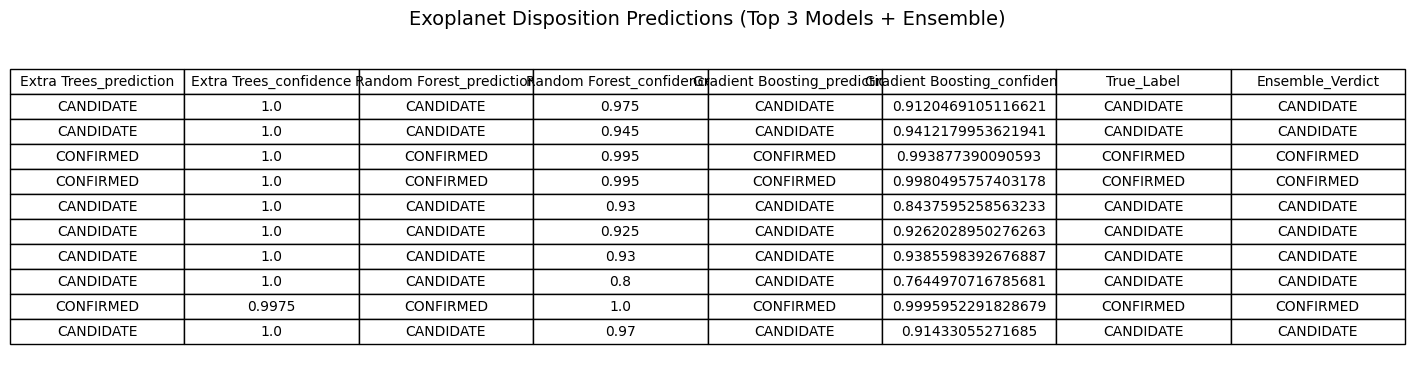

In [22]:
# Make an image
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(18, 4))
ax.axis("off")

# Create table
table = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    loc="center",
    cellLoc="center"
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Title
plt.title(
    "Exoplanet Disposition Predictions (Top 3 Models + Ensemble)",
    fontsize=14,
    pad=20
)

plt.show()

In [23]:
fig.savefig(
    "../results/exoplanet_predictions_table.png",
    dpi=300,
    bbox_inches="tight"
)

### Usage Demo Interpretation

The table above shows predictions from the top three models (Extra Trees, Random Forest, and Gradient Boosting) for each KOI, along with their confidence scores.

- Individual models show strong agreement on most CONFIRMED planets.
- Disagreements primarily occur in the CANDIDATE class, reflecting the inherent ambiguity of borderline transit signals.
- The ensemble majority-vote decision provides a more robust final verdict by reducing individual model bias.

This demonstrates how the trained models can be used in practice to support exoplanet validation and prioritization.


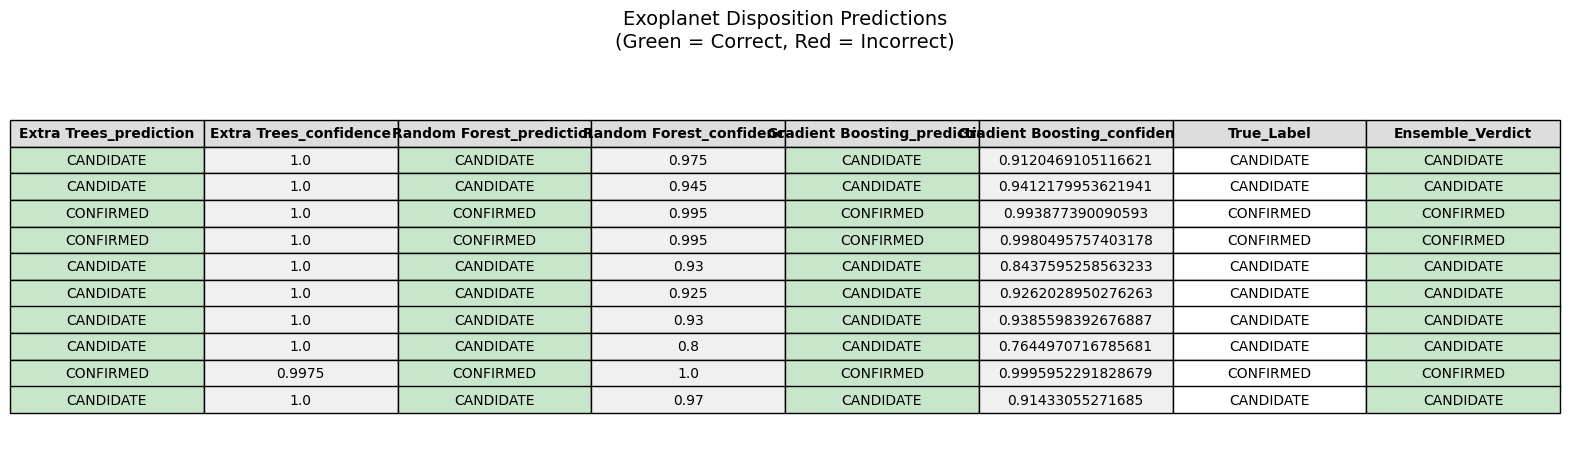

In [24]:
# Generate coloured table
PREDICTION_COLUMNS = [
    "Extra Trees_prediction",
    "Random Forest_prediction",
    "Gradient Boosting_prediction",
    "Ensemble_Verdict"
]

table_df = usage_results.head(10)

fig, ax = plt.subplots(figsize=(20, 5))
ax.axis("off")

table = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    loc="center",
    cellLoc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.6)

# Header styling
for col in range(len(table_df.columns)):
    cell = table[(0, col)]
    cell.set_facecolor("#DDDDDD")
    cell.set_text_props(weight="bold")

# Apply coloring logic
for row in range(1, len(table_df) + 1):
    true_label = table_df.iloc[row - 1]["True_Label"]

    for col, col_name in enumerate(table_df.columns):

        cell = table[(row, col)]

        # Skip ID and confidence columns
        if "confidence" in col_name.lower() or col_name == "Exoplanet_ID":
            cell.set_facecolor("#F0F0F0")
            continue

        # Prediction correctness
        if col_name in PREDICTION_COLUMNS:
            pred = table_df.iloc[row - 1][col_name]
            if pred == true_label:
                cell.set_facecolor("#C8E6C9")  # green
            else:
                cell.set_facecolor("#FFCDD2")  # red

# Title
plt.title(
    "Exoplanet Disposition Predictions\n(Green = Correct, Red = Incorrect)",
    fontsize=14,
    pad=20
)

plt.show()
